In [1]:
import os
os.chdir(os.path.dirname(os.path.dirname(os.getcwd())))

In [65]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
# add MAE
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import scienceplots
plt.style.use(['science'])

In [66]:
def get_power_norm(phase):
    power = pd.read_csv(f'debug_logs/real_power_gurobi_phase_{phase}_step_leap_1_forecast_step_1.csv')
    power = power.melt(id_vars=['time_step'], var_name='building', value_name='net_target')
    power = power.sort_values(by=['time_step', 'building'])
    power['building'] = power['building'].str[-1].astype(int)
    power = power[power['time_step'] != -1]
    lead_times = [f'+{i}h' for i in range(24)]
    power_norm = pd.DataFrame()
    for building in range(7):
        power_norm_temp = pd.DataFrame()
        power_norm_temp['time_step'] = power.loc[power['building'] == building, 'time_step']
        power_norm_temp['building'] = building
        power_norm_temp['net_target'] = power.loc[power['building'] == building, 'net_target']
        for i, lead_time in enumerate(lead_times):
            power_norm_temp[lead_time] = power_norm_temp['net_target'].shift(-int(i))
        power_norm = pd.concat([power_norm, power_norm_temp], axis=0)
    power_norm = power_norm.dropna()
    power_norm = power_norm.sort_values(by=['time_step', 'building'])
    power_norm = power_norm.drop(columns=['net_target'])
    power_norm = power_norm.set_index(['time_step', 'building'])
    return power_norm

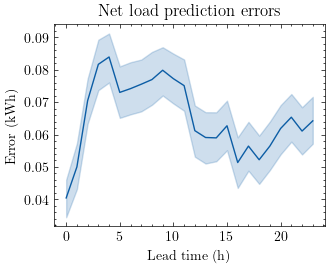

In [70]:
step_forecast = 1
step_optim = 1
phase_num = 3
power_norm = get_power_norm(3)
num_buildings = power_norm.index.get_level_values('building').nunique()

tog_forecast = pd.read_csv(f'debug_logs/scen_gurobi_phase_{phase_num}_step_leap_1_forecast_step_{step_forecast}.csv', 
                index_col=['time_step', 'building'],
                usecols=lambda col: col != 'scenario')
tog_forecast = tog_forecast.loc[power_norm.index]
average_errors = pd.DataFrame()
# return the building column
for b_num in range(num_buildings):
    tog_forecast_temp = tog_forecast.loc[(slice(None), b_num), :]
    power_norm_temp = power_norm.loc[tog_forecast_temp.index]
    # plot 
    errors = power_norm_temp - tog_forecast_temp
    # plot autocorrelation within prediciton errors within the horizon ['+0h', '+1h', '+2h', '+3h', '+4h', '+5h', '+6h', '+7h', '+8h', '+9h', '+10h', '+11h', '+12h', '+13h', '+14h', '+15h', '+16h', '+17h', '+18h', '+19h', '+20h', '+21h', '+22h', '+23h']
    errors = errors.reset_index()
    errors = errors.drop(columns=['building'])
    errors = errors.set_index('time_step')
    errors = errors.stack()
    errors = errors.reset_index()
    errors.columns = ['time_step', 'lead_time', 'error']
    errors['lead_time'] = errors['lead_time'].str.replace('h', '').astype(int)
    errors = errors.sort_values(by=['time_step', 'lead_time'])
    errors = errors.set_index(['time_step', 'lead_time'])
    average_errors = pd.concat([average_errors, errors], axis=0)

# mean errors with same multiindex
average_errors = average_errors.reset_index()
average_errors = average_errors.groupby(['time_step', 'lead_time']).mean()
    
# plot
plt.figure()
sns.lineplot(data=average_errors, x='lead_time', y='error')
plt.xlabel('Lead time (h)')
plt.ylabel('Error (kWh)')
plt.title(f'Net load prediction errors')
plt.show()

In [43]:
100/len(tog_forecast_temp) * 2 * np.abs(power_norm_temp - tog_forecast_temp)  / (np.abs(power_norm_temp) + np.abs(tog_forecast_temp))

,,+0h,+1h,+2h,+3h,+4h,+5h,+6h,+7h,+8h,+9h,...,+14h,+15h,+16h,+17h,+18h,+19h,+20h,+21h,+22h,+23h
time_step,building,,,,,,,,,,,,,,,,,,,,,
0,6,0.000529,0.002225,0.001428,0.003063,0.001889,0.001013,0.022894,0.022894,0.007607,0.000066,...,0.022894,0.018146,0.015642,0.012486,0.008201,0.013913,0.012492,0.012916,0.006049,0.001514
1,6,0.002372,0.001465,0.003222,0.002187,0.001773,0.022894,0.022262,0.007156,0.000592,0.011885,...,0.021962,0.016319,0.013154,0.008340,0.014140,0.013116,0.013624,0.006678,0.001637,0.010365
2,6,0.000265,0.002251,0.000856,0.000769,0.022894,0.021998,0.005990,0.000958,0.012876,0.022894,...,0.016351,0.013330,0.008353,0.013981,0.013027,0.013584,0.006783,0.001725,0.010676,0.008603
3,6,0.002086,0.000802,0.001139,0.022894,0.021649,0.006668,0.001231,0.012479,0.022894,0.022894,...,0.013168,0.008335,0.013983,0.012983,0.013413,0.006700,0.001571,0.010778,0.009091,0.000327
4,6,0.000640,0.000382,0.022894,0.022894,0.006475,0.000431,0.012520,0.022894,0.022894,0.022894,...,0.008411,0.013976,0.012770,0.013491,0.006628,0.001699,0.010755,0.009323,0.001192,0.011503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8731,6,0.004570,0.006833,0.003811,0.015094,0.002031,0.001858,0.013828,0.012836,0.009934,0.004302,...,0.022894,0.022894,0.022894,0.017395,0.014240,0.022894,0.003825,0.000600,0.001321,0.000179
8732,6,0.005937,0.003802,0.015855,0.001944,0.002188,0.013698,0.013138,0.010158,0.003247,0.006847,...,0.022894,0.022894,0.017493,0.010465,0.022894,0.004290,0.000572,0.001380,0.000375,0.011402
8733,6,0.005152,0.016738,0.003220,0.001748,0.013591,0.012911,0.010184,0.002698,0.007184,0.020422,...,0.022894,0.020375,0.008702,0.022894,0.004945,0.000764,0.000998,0.000427,0.011153,0.000399


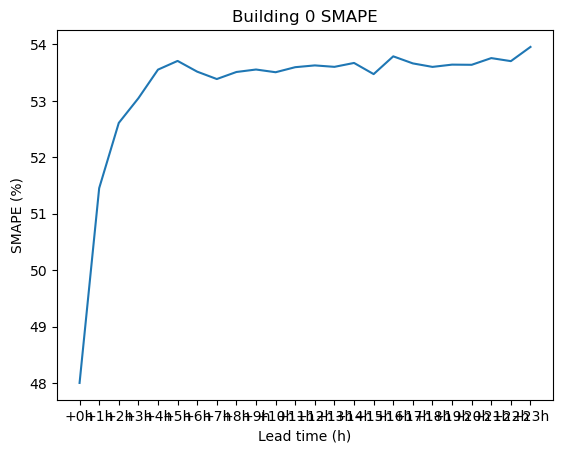

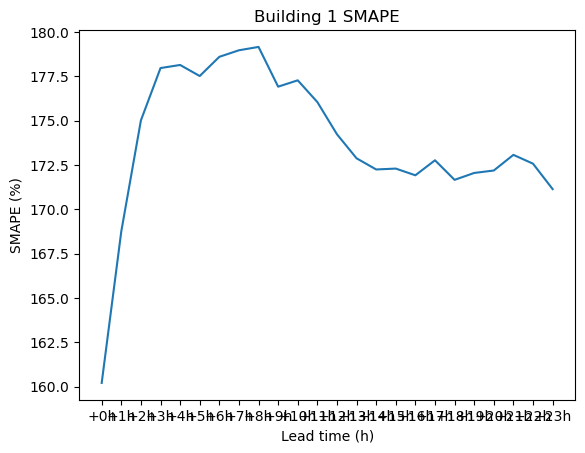

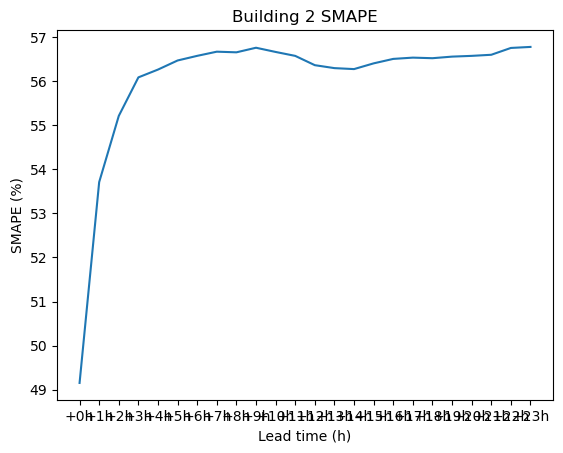

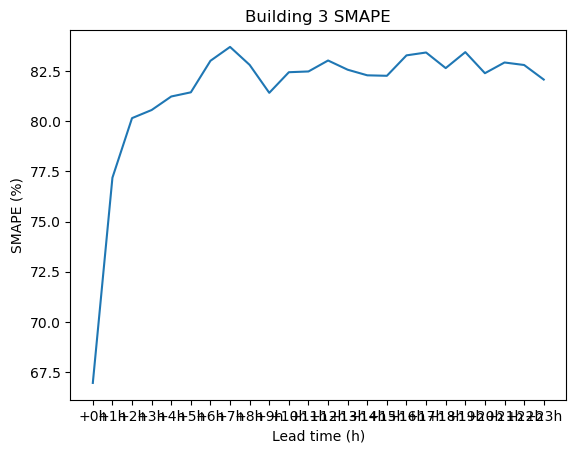

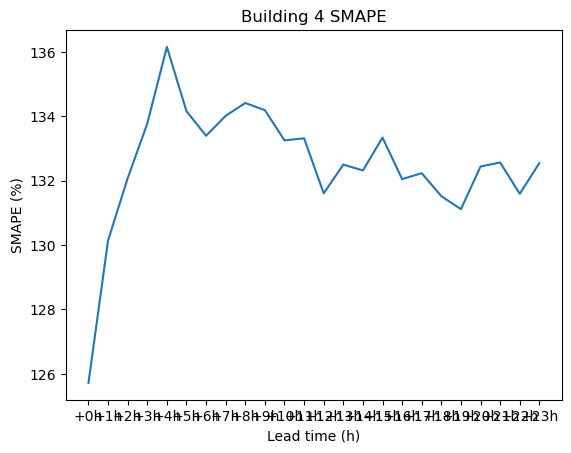

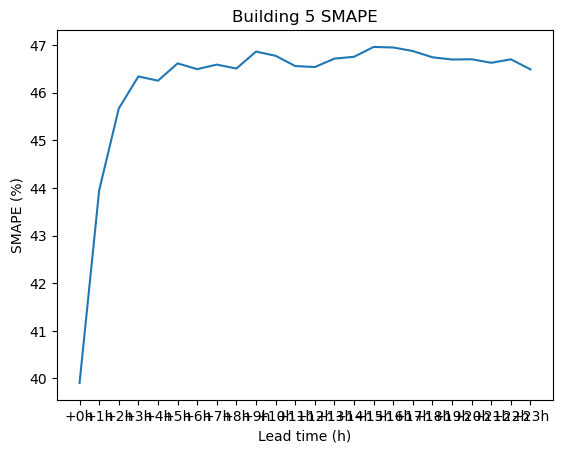

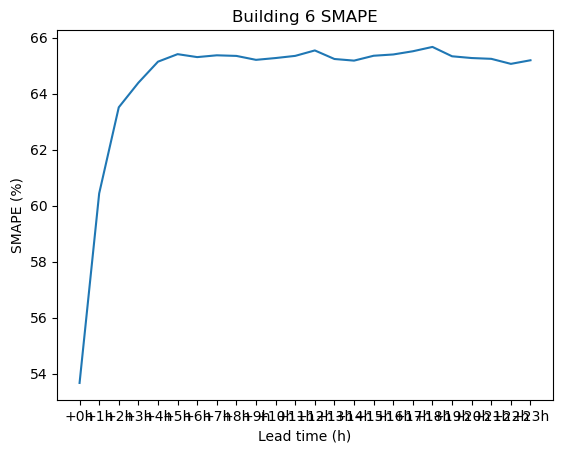

In [52]:
step_forecast = 1
step_optim = 1
phase_num = 3
power_norm = get_power_norm(3)
num_buildings = power_norm.index.get_level_values('building').nunique()

tog_forecast = pd.read_csv(f'debug_logs/scen_gurobi_phase_{phase_num}_step_leap_1_forecast_step_{step_forecast}.csv', 
                index_col=['time_step', 'building'],
                usecols=lambda col: col != 'scenario')
tog_forecast = tog_forecast.loc[power_norm.index]

for b_num in range(num_buildings):
    tog_forecast_temp = tog_forecast.loc[(slice(None), b_num), :]
    power_norm_temp = power_norm.loc[tog_forecast_temp.index]
    
    # Calculate SMAPE
    smape = 100/len(tog_forecast_temp) * np.sum(2 * np.abs(power_norm_temp - tog_forecast_temp) / (np.abs(power_norm_temp) + np.abs(tog_forecast_temp)))
    
    # # plot autocorrelation within prediction errors within the horizon ['+0h', '+1h', '+2h', '+3h', '+4h', '+5h', '+6h', '+7h', '+8h', '+9h', '+10h', '+11h', '+12h', '+13h', '+14h', '+15h', '+16h', '+17h', '+18h', '+19h', '+20h', '+21h', '+22h', '+23h']
    # make series a dataframe with a column smape
    smape = pd.DataFrame(smape, columns=['smape'])
    smape['lead_time'] = smape.index

    plt.figure()
    sns.lineplot(data=smape, x='lead_time', y='smape')
    plt.xlabel('Lead time (h)')
    plt.ylabel('SMAPE (%)')
    plt.title(f'Building {b_num} SMAPE')
    plt.show()

In [71]:
errors = errors.reset_index()
# Pivot the DataFrame to make each lead time a column
pivot_df = errors.pivot(index='time_step', columns='lead_time', values='error')

# Calculate the correlation matrix
correlation_matrix = pivot_df.corr()

# Plot the correlation matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation of Prediction Errors between Lead Times')
plt.show()

RuntimeError: latex was not able to process the following string:
b'lead_time'

Here is the full report generated by latex:
This is pdfTeX, Version 3.141592653-2.6-1.40.25 (TeX Live 2023) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(/Users/evgenygenov/.matplotlib/tex.cache/ece98cb32d6b149f8f7a711326ce0697.tex
LaTeX2e <2022-11-01> patch level 1
L3 programming layer <2023-02-22>
(/usr/local/texlive/2023/texmf-dist/tex/latex/base/article.cls
Document Class: article 2022/07/02 v1.4n Standard LaTeX document class
(/usr/local/texlive/2023/texmf-dist/tex/latex/base/size10.clo))
(/usr/local/texlive/2023/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/local/texlive/2023/texmf-dist/tex/latex/cm-super/type1ec.sty
(/usr/local/texlive/2023/texmf-dist/tex/latex/base/t1cmr.fd))
(/usr/local/texlive/2023/texmf-dist/tex/latex/base/inputenc.sty)
(/usr/local/texlive/2023/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/local/texlive/2023/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/local/texlive/2023/texmf-dist/tex/generic/iftex/ifvtex.sty
(/usr/local/texlive/2023/texmf-dist/tex/generic/iftex/iftex.sty)))
(/usr/local/texlive/2023/texmf-dist/tex/latex/amsmath/amsmath.sty
For additional information on amsmath, use the `?' option.
(/usr/local/texlive/2023/texmf-dist/tex/latex/amsmath/amstext.sty
(/usr/local/texlive/2023/texmf-dist/tex/latex/amsmath/amsgen.sty))
(/usr/local/texlive/2023/texmf-dist/tex/latex/amsmath/amsbsy.sty)
(/usr/local/texlive/2023/texmf-dist/tex/latex/amsmath/amsopn.sty))
(/usr/local/texlive/2023/texmf-dist/tex/latex/amsfonts/amssymb.sty
(/usr/local/texlive/2023/texmf-dist/tex/latex/amsfonts/amsfonts.sty))
(/usr/local/texlive/2023/texmf-dist/tex/latex/base/textcomp.sty)
(/usr/local/texlive/2023/texmf-dist/tex/latex/l3backend/l3backend-dvips.def)
No file ece98cb32d6b149f8f7a711326ce0697.aux.
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Missing $ inserted.
<inserted text> 
                $
l.19 {\rmfamily lead_
                     time}
No pages of output.
Transcript written on ece98cb32d6b149f8f7a711326ce0697.log.




<Figure size 1000x800 with 2 Axes>

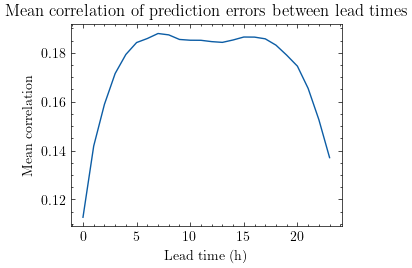

In [72]:
errors = errors.reset_index()
# Pivot the DataFrame to make each lead time a column
pivot_df = errors.pivot(index='time_step', columns='lead_time', values='error')

# Calculate the correlation matrix
correlation_matrix = pivot_df.corr()

# plot mean correlation for each lead time
plt.figure()
sns.lineplot(data=correlation_matrix.mean(axis=0))
plt.xlabel('Lead time (h)')
plt.ylabel('Mean correlation')
plt.title('Mean correlation of prediction errors between lead times')
plt.show()

In [4]:
power = pd.read_csv('debug_logs/real_power_gurobi_phase_3_step_leap_1_forecast_step_1.csv')
power = power.melt(id_vars=['time_step'], var_name='building', value_name='net_target')
power = power.sort_values(by=['time_step', 'building'])
power['building'] = power['building'].str[-1].astype(int)
power = power[power['time_step'] != -1]
lead_times = [f'+{i}h' for i in range(24)]
# upload min-max scaler from scalers folders with .save extension
power_norm = pd.DataFrame()
for building in range(7):
    power_norm_temp = pd.DataFrame()
    power_norm_temp['time_step'] = power.loc[power['building'] == building, 'time_step']
    power_norm_temp['building'] = building
    power_norm_temp['net_target'] = power.loc[power['building'] == building, 'net_target']
    for i, lead_time in enumerate(lead_times):
        power_norm_temp[lead_time] = power_norm_temp['net_target'].shift(-int(i))
    power_norm = pd.concat([power_norm, power_norm_temp], axis=0)
power_norm = power_norm.dropna()
power_norm = power_norm.sort_values(by=['time_step', 'building'])
# drop the net_target column
power_norm = power_norm.drop(columns=['net_target'])
# set the index to time_step and building
power_norm = power_norm.set_index(['time_step', 'building'])
power_norm

+0h           +1h           +2h           +3h  \
time_step building                                                           
0         0         6.907833e-01  6.887500e-01  6.335667e-01  6.768111e-01   
          1         1.000000e-07  1.000000e-07  1.000000e-07  1.000000e-07   
          2         1.405750e+00  1.187467e+00  1.100133e+00  1.247567e+00   
          3         3.328667e-01  7.353000e-01  2.221967e+00  8.956500e-01   
          4         1.000000e-07  1.000000e-07  1.000000e-07  1.000000e-07   
...                          ...           ...           ...           ...   
8735      2         6.969639e-01  3.210000e-01  3.210944e-01  3.088667e-01   
          3         4.002333e-01  3.982500e-01  3.777389e-01  6.308833e-01   
          4         1.000000e-07  1.000000e-07  1.000000e-07  1.000000e-07   
          5         1.114000e+00  1.494167e+00  1.409217e+00  1.421167e+00   
          6         1.227383e+00  1.466233e+00  3.340667e-01  3.619333e-01   

                             +4h           +5h       +6h       +7h       +8h  \
time_step building                                                             
0         0         6.204500e-01  1.463322e+00  1.589600  0.230944  0.224400   
          1         1.000000e-07 -4.568323e-02  0.074033  0.331600  0.985483   
          2         7.937833e-01  9.422500e-01  1.120967  1.330017  0.269967   
          3         3.305833e-01  4.994500e-01  3.203350 -0.007133 -0.404317   
          4         1.000000e-07  1.000000e-07  0.069367  0.495367  1.215700   
...                          ...           ...       ...       ...       ...   
8735      2         3.979000e-01  4.443667e-01  0.261883  0.903417 -0.208967   
          3         2.034978e+00  4.323000e-01  0.202372 -0.081250 -0.404711   
          4         1.000000e-07  1.000000e-07 -0.080200  0.353133  1.000117   
          5         1.377900e+00  1.404483e+00  1.528767  1.095467  0.279600   
          6         3.675000e-01  1.177217e+00  1.352033 -0.945517 -1.489833   

                         +9h  ...      +14h      +15h      +16h      +17h  \
time_step building            ...                                           
0         0        -0.346778  ... -0.517433 -0.148833  0.445283  1.518111   
          1         1.902900  ... -0.023517 -0.355717 -0.244867 -0.174317   
          2         0.224567  ...  0.305383 -0.234767  0.502983  0.846617   
          3        -0.658783  ... -0.111100 -0.087400 -0.441150  0.256567   
          4         1.586317  ...  0.246533  0.060083  0.088150  0.002800   
...                      ...  ...       ...       ...       ...       ...   
8735      2         0.269117  ... -1.717206  0.196217  1.476428  2.158550   
          3        -0.662000  ...  1.747511  1.755267  2.693389  3.650067   
          4         1.832300  ...  3.023450  2.676717  2.130667  1.408808   
          5         0.487600  ... -1.725900  0.125133  0.400967 -0.025800   
          6        -2.205650  ...  0.941767 -1.639083  1.222650  2.820967   

                            +18h          +19h          +20h          +21h  \
time_step building                                                           
0         0         2.988317e+00  3.048861e+00  3.568817e+00  2.022833e+00   
          1        -1.911658e-02  1.000000e-07  1.000000e-07  1.000000e-07   
          2         2.221517e+00  1.808833e+00  2.170200e+00  1.665800e+00   
          3         2.051300e+00  4.820833e-01  8.071167e-01  4.758667e-01   
          4         1.000000e-07  1.000000e-07  1.000000e-07  1.000000e-07   
...                          ...           ...           ...           ...   
8735      2         1.526644e+00  3.313683e+00  1.880772e+00  3.529250e+00   
          3         3.671528e+00  2.727883e+00  1.323300e+00  1.507017e+00   
          4         5.775250e-01 -3.678333e-02  1.000000e-07  1.000000e-07   
          5         3.426450e+00  1.699617e+00  1.798450e+00  1.804633e+00   
          6         3.207700e+00  3